In [ ]:
import sklearn
sklearn.__version__

'1.6.1'

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
import time
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             roc_curve,
                             auc, accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score, roc_auc_score)

In [ ]:
# Загрузка и первичный просмотр данных
df = pd.read_csv(r'/Dataset.csv')

print("Размерность датасета:", df.shape)
print("\nПервые 5 строк датасета:")
df.head()

Размерность датасета: (1000000, 32)

Первые 5 строк датасета:


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [ ]:
# Анализ распределения классов и типов данных
print("Общая информация о датасете:")
print(f"Всего транзакций: {len(df)}")
print(f"Нормальные транзакции: {sum(df['fraud_bool'] == 0)}")
print(f"Мошеннические транзакции: {sum(df['fraud_bool'] == 1)}")
print(f"Процент мошеннических транзакций: {(sum(df['fraud_bool'] == 1) / len(df)) * 100:.2f}%")

print("\nТипы данных в колонках:")
print(df.dtypes)

Общая информация о датасете:
Всего транзакций: 1000000
Нормальные транзакции: 988971
Мошеннические транзакции: 11029
Процент мошеннических транзакций: 1.10%

Типы данных в колонках:
fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status            

In [ ]:
X = df.drop('fraud_bool', axis=1)
y = df['fraud_bool']

#X, X_, y, y_ = train_test_split(X, y, test_size=0.9, stratify=y)

In [ ]:
# Разделяем признаки на числовые и категориальные
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("Исходные признаки:")
print("Числовые признаки:", numeric_features.tolist())
print("Категориальные признаки:", categorical_features.tolist())
print("Количество исходных признаков:", len(numeric_features) + len(categorical_features))

Исходные признаки:
Числовые признаки: ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']
Категориальные признаки: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
Количество исходных признаков: 31


In [ ]:
# Преобразование категориальных признаков
if len(categorical_features) > 0:
    # encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoder = TargetEncoder(smooth="auto")
    X_categorical = encoder.fit_transform(X[categorical_features], y)
    categorical_feature_names = encoder.get_feature_names_out(categorical_features)
    X_categorical = pd.DataFrame(X_categorical, columns=categorical_feature_names, index=X.index)

    # print("\nПосле One-Hot Encoding:")
    # print("Количество признаков после One-Hot Encoding категориальных:", len(categorical_feature_names))
    # print("Названия признаков после One-Hot Encoding:", categorical_feature_names.tolist())

    # Стандартизация числовых признаков
    scaler = StandardScaler()
    X_numeric = scaler.fit_transform(X[numeric_features])
    X_numeric = pd.DataFrame(X_numeric, columns=numeric_features, index=X.index)

    # Объединяем преобразованные признаки
    X_scaled = pd.concat([X_numeric, X_categorical], axis=1)
else:
    # Если нет категориальных признаков, только стандартизируем числовые
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("\nИтоговое количество признаков:")
print("Числовые:", len(numeric_features))
print("После One-Hot Encoding:", len(categorical_feature_names) if len(categorical_features) > 0 else 0)
print("Всего:", X_scaled.shape[1])


Итоговое количество признаков:
Числовые: 26
После One-Hot Encoding: 5
Всего: 31


In [ ]:
# Разделение на обучающую и тестовую выборки
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Выделение нормальных транзакций для обучения
X_train_normal = X_train_scaled[y_train == 0]

print("\nФорма обучающих данных после преобразования:", X_train_scaled.shape)
print("Форма тестовых данных после преобразования:", X_test_scaled.shape)



Форма обучающих данных после преобразования: (700000, 31)
Форма тестовых данных после преобразования: (300000, 31)


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок - {title}')
    plt.ylabel('Истинное значение')
    plt.xlabel('Предсказанное значение')
    plt.show()

def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривая - {title}')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

## **Метод: Isolation Forest**


Метод: Isolation Forest - ОБУЧЕНИЕ

Метрики на обучающей выборке:
Accuracy: 0.8941
Precision: 0.0257
Recall: 0.2330
F1-score: 0.0463
ROC AUC: 0.6636
Время обучения: 27.3183 сек.
Время предсказания: 24.1063 сек.


<Figure size 800x600 with 0 Axes>

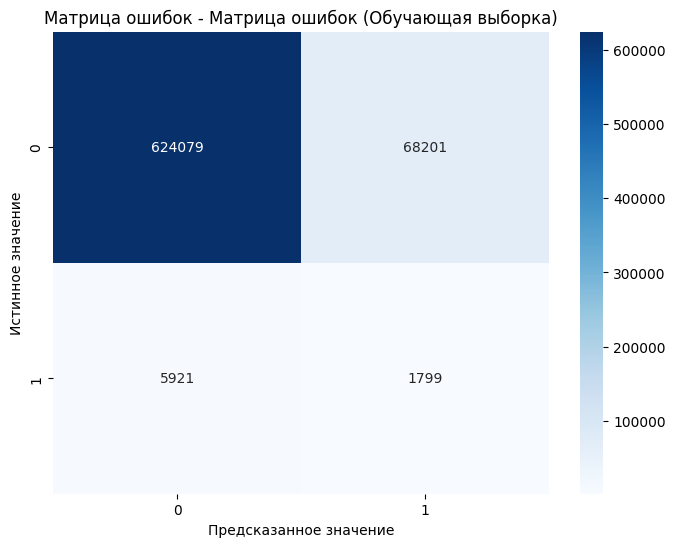

<Figure size 800x600 with 0 Axes>

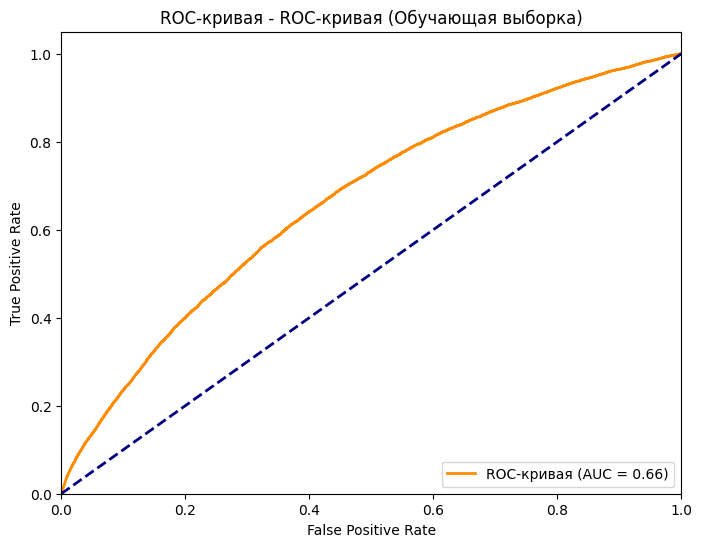

In [ ]:
# ISOLATION FOREST
print(f"\n{'='*50}")
print("Метод: Isolation Forest - ОБУЧЕНИЕ")
print(f"{'='*50}")

# Обучение
start_time = time.time()
iforest = IsolationForest(random_state=42, contamination=0.1, n_estimators=500, n_jobs=-1)
iforest.fit(X_train_scaled)
train_time_iforest = time.time() - start_time

# Предсказание на обучающей выборке
start_time = time.time()
y_pred_train_iforest = (iforest.predict(X_train_scaled) == -1).astype(int)
train_pred_time_iforest = time.time() - start_time
y_score_train_iforest = -iforest.decision_function(X_train_scaled)

# Метрики на обучающей выборке
train_acc_iforest = accuracy_score(y_train, y_pred_train_iforest)
train_prec_iforest = precision_score(y_train, y_pred_train_iforest)
train_rec_iforest = recall_score(y_train, y_pred_train_iforest)
train_f1_iforest = f1_score(y_train, y_pred_train_iforest)
train_roc_iforest = roc_auc_score(y_train, y_score_train_iforest)

# Вывод метрик обучающей выборки
print("\nМетрики на обучающей выборке:")
print(f"Accuracy: {train_acc_iforest:.4f}")
print(f"Precision: {train_prec_iforest:.4f}")
print(f"Recall: {train_rec_iforest:.4f}")
print(f"F1-score: {train_f1_iforest:.4f}")
print(f"ROC AUC: {train_roc_iforest:.4f}")
print(f"Время обучения: {train_time_iforest:.4f} сек.")
print(f"Время предсказания: {train_pred_time_iforest:.4f} сек.")

# Матрица ошибок для обучающей выборки
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_train, y_pred_train_iforest, title='Матрица ошибок (Обучающая выборка)')
plt.show()

# ROC-кривая для обучающей выборки
plt.figure(figsize=(8, 6))
plot_roc_curve(y_train, y_score_train_iforest, title='ROC-кривая (Обучающая выборка)')
plt.show()


Метод: Isolation Forest - ТЕСТИРОВАНИЕ

Метрики на тестовой выборке:
Accuracy: 0.8935
Precision: 0.0250
Recall: 0.2279
F1-score: 0.0451
ROC AUC: 0.6632
Время предсказания: 13.1366 сек.


<Figure size 800x600 with 0 Axes>

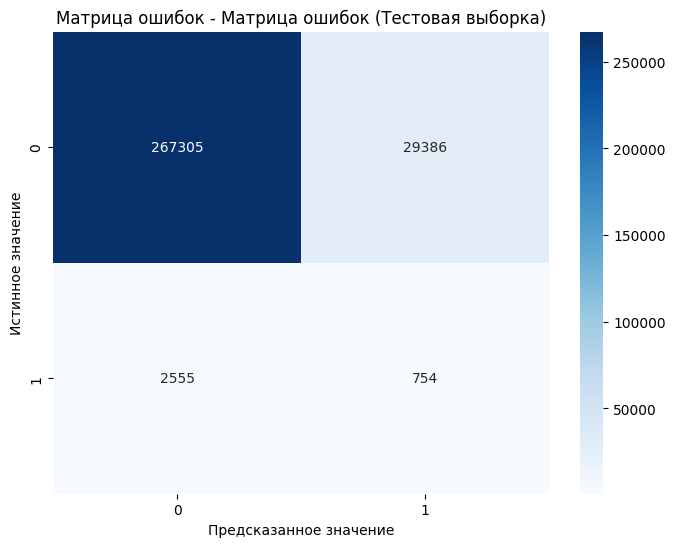

<Figure size 800x600 with 0 Axes>

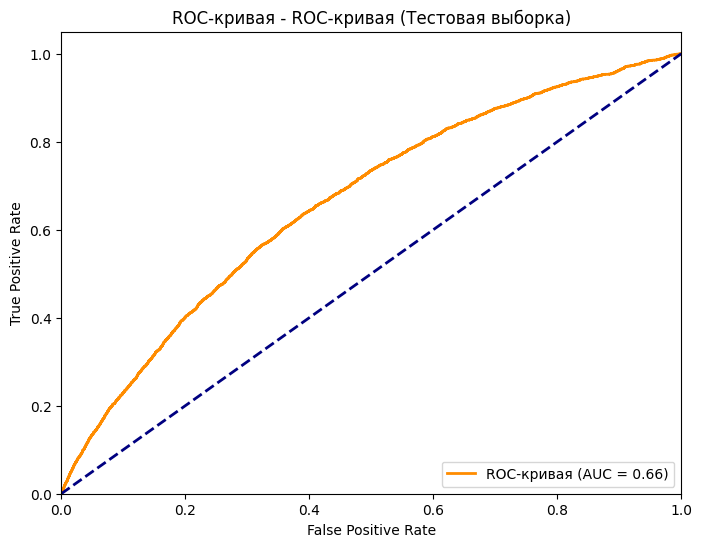

In [ ]:
print(f"\n{'='*50}")
print("Метод: Isolation Forest - ТЕСТИРОВАНИЕ")
print(f"{'='*50}")

# Предсказание на тестовой выборке
start_time = time.time()
y_pred_test_iforest = (iforest.predict(X_test_scaled) == -1).astype(int)
test_pred_time_iforest = time.time() - start_time
y_score_test_iforest = -iforest.decision_function(X_test_scaled)

# Метрики на тестовой выборке
test_acc_iforest = accuracy_score(y_test, y_pred_test_iforest)
test_prec_iforest = precision_score(y_test, y_pred_test_iforest)
test_rec_iforest = recall_score(y_test, y_pred_test_iforest)
test_f1_iforest = f1_score(y_test, y_pred_test_iforest)
test_roc_iforest = roc_auc_score(y_test, y_score_test_iforest)

# Вывод метрик тестовой выборки
print("\nМетрики на тестовой выборке:")
print(f"Accuracy: {test_acc_iforest:.4f}")
print(f"Precision: {test_prec_iforest:.4f}")
print(f"Recall: {test_rec_iforest:.4f}")
print(f"F1-score: {test_f1_iforest:.4f}")
print(f"ROC AUC: {test_roc_iforest:.4f}")
print(f"Время предсказания: {test_pred_time_iforest:.4f} сек.")

# Матрица ошибок для тестовой выборки
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_test, y_pred_test_iforest, title='Матрица ошибок (Тестовая выборка)')
plt.show()

# ROC-кривая для тестовой выборки
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_score_test_iforest, title='ROC-кривая (Тестовая выборка)')
plt.show()

In [ ]:
# Сохранение результатов Isolation Forest
results_iforest = {
    'train_accuracy_iforest': train_acc_iforest,
    'train_precision_iforest': train_prec_iforest,
    'train_recall_iforest': train_rec_iforest,
    'train_f1_iforest': train_f1_iforest,
    'train_roc_auc_iforest': train_roc_iforest,
    'train_time_iforest': train_time_iforest,
    'train_pred_time_iforest': train_pred_time_iforest,
    'test_accuracy_iforest': test_acc_iforest,
    'test_precision_iforest': test_prec_iforest,
    'test_recall_iforest': test_rec_iforest,
    'test_f1_iforest': test_f1_iforest,
    'test_roc_auc_iforest': test_roc_iforest,
    'test_pred_time_iforest': test_pred_time_iforest
}

## **One-Class SVM**

In [ ]:
X_train_scaled.fillna(-1, inplace=True)
X_test_scaled.fillna(-1, inplace=True)


Метод: One-Class SVM - ОБУЧЕНИЕ

Метрики на обучающей выборке:
Accuracy: 0.8937
Precision: 0.0236
Recall: 0.2144
F1-score: 0.0426
ROC AUC: 0.6251
Время обучения: 14009.4275 сек.
Время предсказания: 4237.0723 сек.


<Figure size 800x600 with 0 Axes>

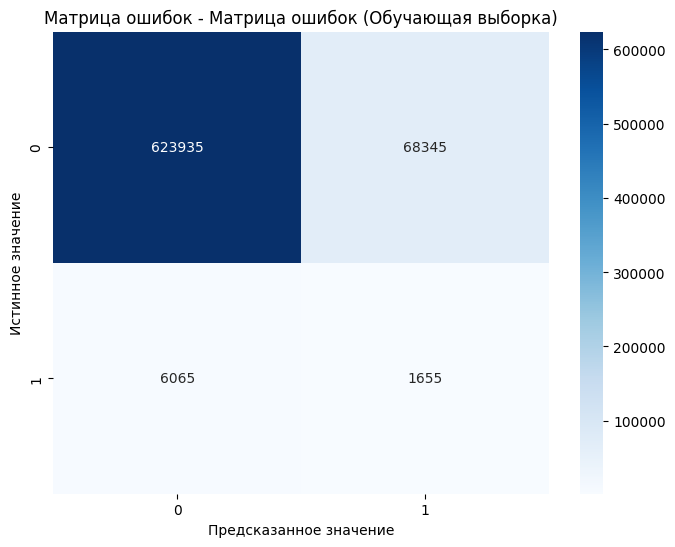

<Figure size 800x600 with 0 Axes>

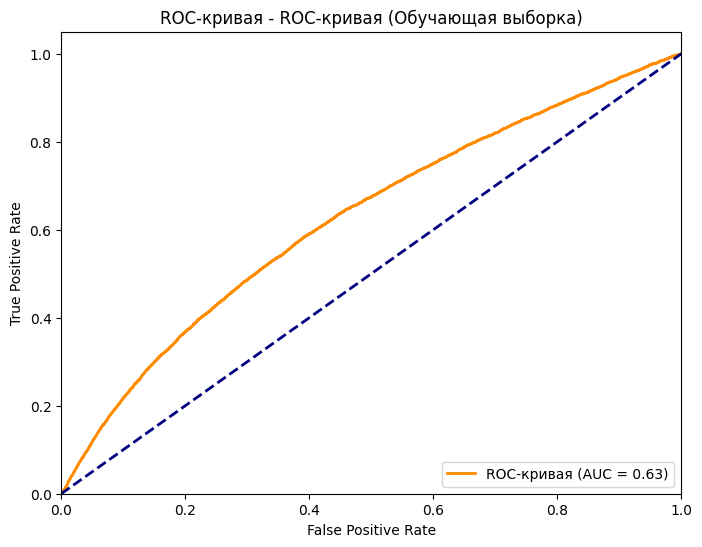

In [ ]:
# ONE-CLASS SVM
print(f"\n{'='*50}")
print("Метод: One-Class SVM - ОБУЧЕНИЕ")
print(f"{'='*50}")

# Обучение
start_time = time.time()
ocsvm = OneClassSVM(kernel='rbf', nu=0.1)
ocsvm.fit(X_train_scaled)
train_time_ocsvm = time.time() - start_time

# Предсказание на обучающей выборке
start_time = time.time()
y_pred_train_ocsvm = (ocsvm.predict(X_train_scaled) == -1).astype(int)
train_pred_time_ocsvm = time.time() - start_time
y_score_train_ocsvm = -ocsvm.decision_function(X_train_scaled)

# Метрики на обучающей выборке
train_acc_ocsvm = accuracy_score(y_train, y_pred_train_ocsvm)
train_prec_ocsvm = precision_score(y_train, y_pred_train_ocsvm)
train_rec_ocsvm = recall_score(y_train, y_pred_train_ocsvm)
train_f1_ocsvm = f1_score(y_train, y_pred_train_ocsvm)
train_roc_ocsvm = roc_auc_score(y_train, y_score_train_ocsvm)

# Вывод метрик обучающей выборки
print("\nМетрики на обучающей выборке:")
print(f"Accuracy: {train_acc_ocsvm:.4f}")
print(f"Precision: {train_prec_ocsvm:.4f}")
print(f"Recall: {train_rec_ocsvm:.4f}")
print(f"F1-score: {train_f1_ocsvm:.4f}")
print(f"ROC AUC: {train_roc_ocsvm:.4f}")
print(f"Время обучения: {train_time_ocsvm:.4f} сек.")
print(f"Время предсказания: {train_pred_time_ocsvm:.4f} сек.")

# Матрица ошибок для обучающей выборки
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_train, y_pred_train_ocsvm, title='Матрица ошибок (Обучающая выборка)')
plt.show()

# ROC-кривая для обучающей выборки
plt.figure(figsize=(8, 6))
plot_roc_curve(y_train, y_score_train_ocsvm, title='ROC-кривая (Обучающая выборка)')
plt.show()


Метрики на тестовой выборке:
Accuracy: 0.8930
Precision: 0.0228
Recall: 0.2076
F1-score: 0.0410
ROC AUC: 0.6178
Время предсказания: 1827.3822 сек.


<Figure size 800x600 with 0 Axes>

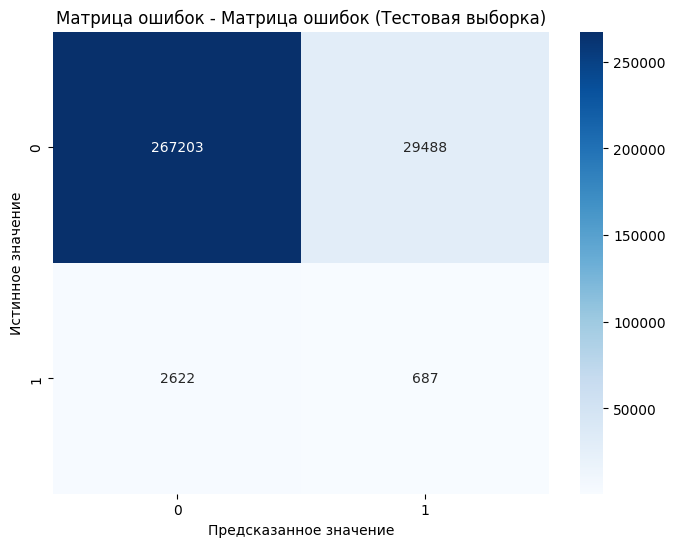

<Figure size 800x600 with 0 Axes>

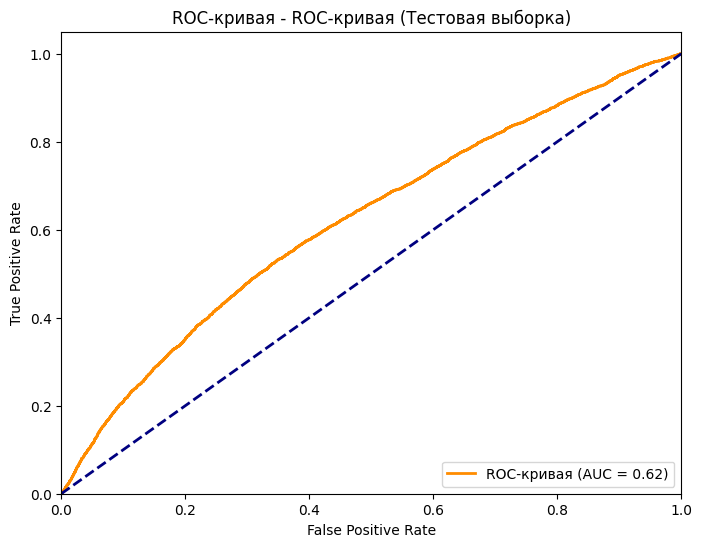

In [ ]:
# Предсказание на тестовой выборке
start_time = time.time()
y_pred_test_ocsvm = (ocsvm.predict(X_test_scaled) == -1).astype(int)
test_pred_time_ocsvm = time.time() - start_time
y_score_test_ocsvm = -ocsvm.decision_function(X_test_scaled)

# Метрики на тестовой выборке
test_acc_ocsvm = accuracy_score(y_test, y_pred_test_ocsvm)
test_prec_ocsvm = precision_score(y_test, y_pred_test_ocsvm)
test_rec_ocsvm = recall_score(y_test, y_pred_test_ocsvm)
test_f1_ocsvm = f1_score(y_test, y_pred_test_ocsvm)
test_roc_ocsvm = roc_auc_score(y_test, y_score_test_ocsvm)

# Вывод метрик тестовой выборки
print("\nМетрики на тестовой выборке:")
print(f"Accuracy: {test_acc_ocsvm:.4f}")
print(f"Precision: {test_prec_ocsvm:.4f}")
print(f"Recall: {test_rec_ocsvm:.4f}")
print(f"F1-score: {test_f1_ocsvm:.4f}")
print(f"ROC AUC: {test_roc_ocsvm:.4f}")
print(f"Время предсказания: {test_pred_time_ocsvm:.4f} сек.")

# Матрица ошибок для тестовой выборки
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_test, y_pred_test_ocsvm, title='Матрица ошибок (Тестовая выборка)')
plt.show()

# ROC-кривая для тестовой выборки
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_score_test_ocsvm, title='ROC-кривая (Тестовая выборка)')
plt.show()


In [ ]:
# Сохранение результатов One-Class SVM
results_ocsvm = {
    'train_accuracy_ocsvm': train_acc_ocsvm,
    'train_precision_ocsvm': train_prec_ocsvm,
    'train_recall_ocsvm': train_rec_ocsvm,
    'train_f1_ocsvm': train_f1_ocsvm,
    'train_roc_auc_ocsvm': train_roc_ocsvm,
    'train_time_ocsvm': train_time_ocsvm,
    'train_pred_time_ocsvm': train_pred_time_ocsvm,
    'test_accuracy_ocsvm': test_acc_ocsvm,
    'test_precision_ocsvm': test_prec_ocsvm,
    'test_recall_ocsvm': test_rec_ocsvm,
    'test_f1_ocsvm': test_f1_ocsvm,
    'test_roc_auc_ocsvm': test_roc_ocsvm,
    'test_pred_time_ocsvm': test_pred_time_ocsvm
}


## **Local Outlier Factor:**



Метод: Local Outlier Factor - ОБУЧЕНИЕ


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



Метрики на обучающей выборке:
Accuracy: 0.8974
Precision: 0.0135
Recall: 0.1148
F1-score: 0.0241
ROC AUC: 0.5301
Время обучения: 3190.6438 сек.
Время предсказания: 3181.7447 сек.


<Figure size 800x600 with 0 Axes>

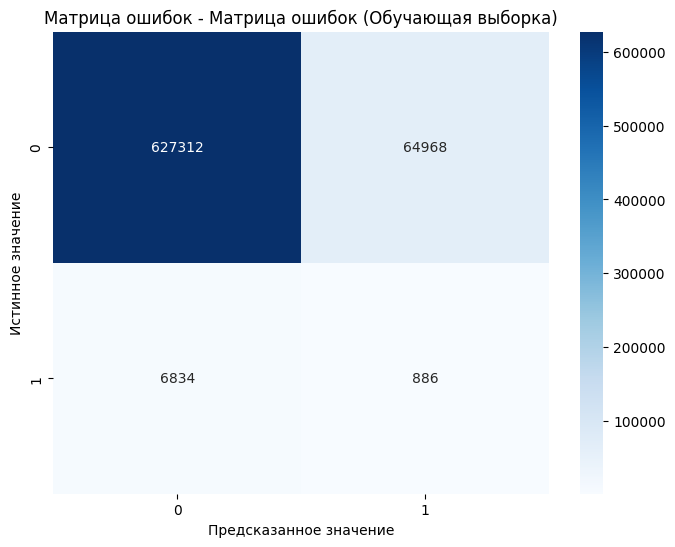

<Figure size 800x600 with 0 Axes>

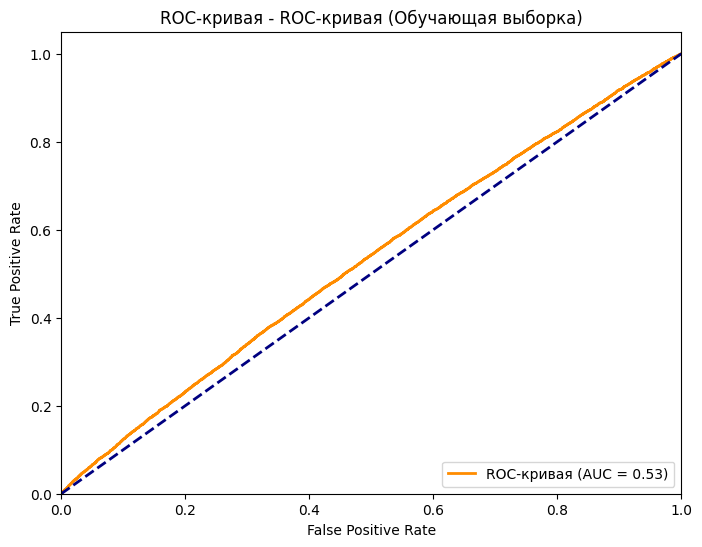

In [ ]:
# LOCAL OUTLIER FACTOR
print(f"\n{'='*50}")
print("Метод: Local Outlier Factor - ОБУЧЕНИЕ")
print(f"{'='*50}")

# Обучение
start_time = time.time()
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.1, novelty=True)
lof.fit(X_train_scaled)
train_time_lof = time.time() - start_time

# Предсказание на обучающей выборке
start_time = time.time()
y_pred_train_lof = (lof.predict(X_train_scaled) == -1).astype(int)
train_pred_time_lof = time.time() - start_time
y_score_train_lof = -lof.decision_function(X_train_scaled)

# Метрики на обучающей выборке
train_acc_lof = accuracy_score(y_train, y_pred_train_lof)
train_prec_lof = precision_score(y_train, y_pred_train_lof)
train_rec_lof = recall_score(y_train, y_pred_train_lof)
train_f1_lof = f1_score(y_train, y_pred_train_lof)
train_roc_lof = roc_auc_score(y_train, y_score_train_lof)

# Вывод метрик обучающей выборки
print("\nМетрики на обучающей выборке:")
print(f"Accuracy: {train_acc_lof:.4f}")
print(f"Precision: {train_prec_lof:.4f}")
print(f"Recall: {train_rec_lof:.4f}")
print(f"F1-score: {train_f1_lof:.4f}")
print(f"ROC AUC: {train_roc_lof:.4f}")
print(f"Время обучения: {train_time_lof:.4f} сек.")
print(f"Время предсказания: {train_pred_time_lof:.4f} сек.")

# Матрица ошибок для обучающей выборки
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_train, y_pred_train_lof, title='Матрица ошибок (Обучающая выборка)')
plt.show()

# ROC-кривая для обучающей выборки
plt.figure(figsize=(8, 6))
plot_roc_curve(y_train, y_score_train_lof, title='ROC-кривая (Обучающая выборка)')
plt.show()


Метод: Local Outlier Factor - ТЕСТИРОВАНИЕ


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



Метрики на тестовой выборке:
Accuracy: 0.8907
Precision: 0.0134
Recall: 0.1224
F1-score: 0.0241
ROC AUC: 0.5265
Время предсказания: 1364.1784 сек.


<Figure size 800x600 with 0 Axes>

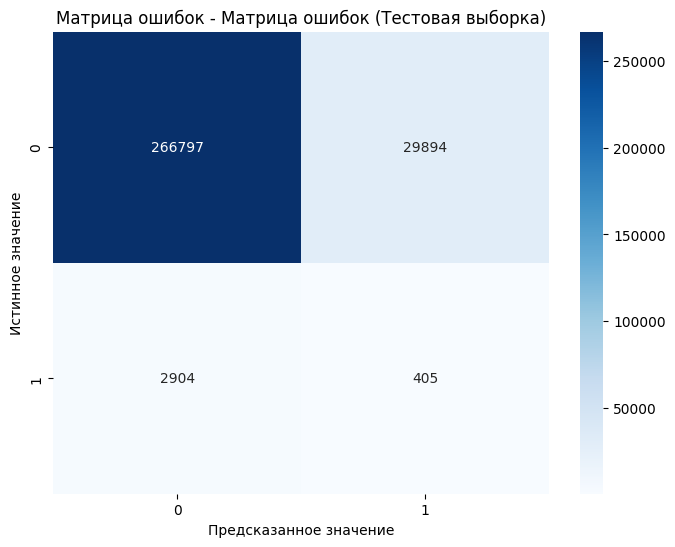

<Figure size 800x600 with 0 Axes>

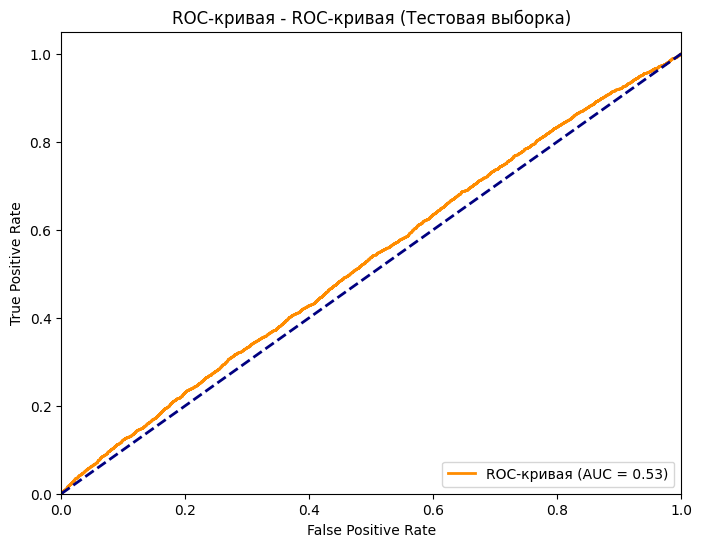

In [ ]:
print(f"\n{'='*50}")
print("Метод: Local Outlier Factor - ТЕСТИРОВАНИЕ")
print(f"{'='*50}")

# Предсказание на тестовой выборке
start_time = time.time()
y_pred_test_lof = (lof.predict(X_test_scaled) == -1).astype(int)
test_pred_time_lof = time.time() - start_time
y_score_test_lof = -lof.decision_function(X_test_scaled)

# Метрики на тестовой выборке
test_acc_lof = accuracy_score(y_test, y_pred_test_lof)
test_prec_lof = precision_score(y_test, y_pred_test_lof)
test_rec_lof = recall_score(y_test, y_pred_test_lof)
test_f1_lof = f1_score(y_test, y_pred_test_lof)
test_roc_lof = roc_auc_score(y_test, y_score_test_lof)

# Вывод метрик тестовой выборки
print("\nМетрики на тестовой выборке:")
print(f"Accuracy: {test_acc_lof:.4f}")
print(f"Precision: {test_prec_lof:.4f}")
print(f"Recall: {test_rec_lof:.4f}")
print(f"F1-score: {test_f1_lof:.4f}")
print(f"ROC AUC: {test_roc_lof:.4f}")
print(f"Время предсказания: {test_pred_time_lof:.4f} сек.")

# Матрица ошибок для тестовой выборки
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_test, y_pred_test_lof, title='Матрица ошибок (Тестовая выборка)')
plt.show()

# ROC-кривая для тестовой выборки
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_score_test_lof, title='ROC-кривая (Тестовая выборка)')
plt.show()

In [ ]:
# Сохранение результатов LOF
results_lof = {
    'train_accuracy_lof': train_acc_lof,
    'train_precision_lof': train_prec_lof,
    'train_recall_lof': train_rec_lof,
    'train_f1_lof': train_f1_lof,
    'train_roc_auc_lof': train_roc_lof,
    'train_time_lof': train_time_lof,
    'train_pred_time_lof': train_pred_time_lof,
    'test_accuracy_lof': test_acc_lof,
    'test_precision_lof': test_prec_lof,
    'test_recall_lof': test_rec_lof,
    'test_f1_lof': test_f1_lof,
    'test_roc_auc_lof': test_roc_lof,
    'test_pred_time_lof': test_pred_time_lof
}

## **Elliptic Envelope:**



Метод: Elliptic Envelope - ОБУЧЕНИЕ


/usr/local/lib/python3.11/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(



Метрики на обучающей выборке:
Accuracy: 0.8932
Precision: 0.0211
Recall: 0.1909
F1-score: 0.0379
ROC AUC: 0.5847
Время обучения: 98.3941 сек.
Время предсказания: 0.4253 сек.


<Figure size 800x600 with 0 Axes>

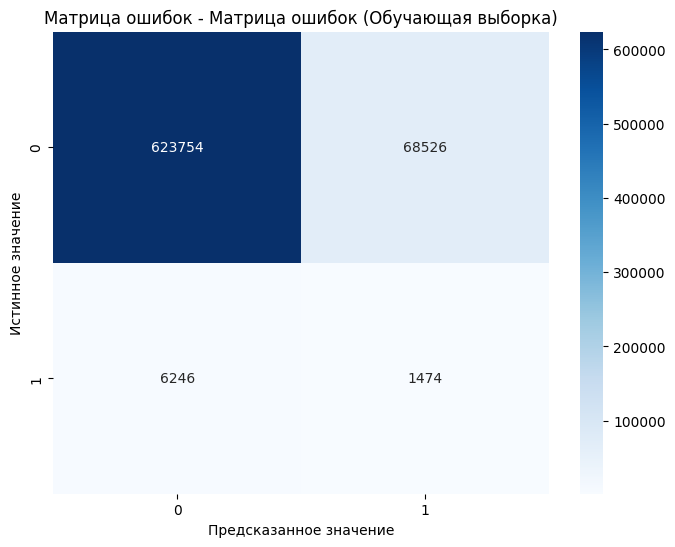

<Figure size 800x600 with 0 Axes>

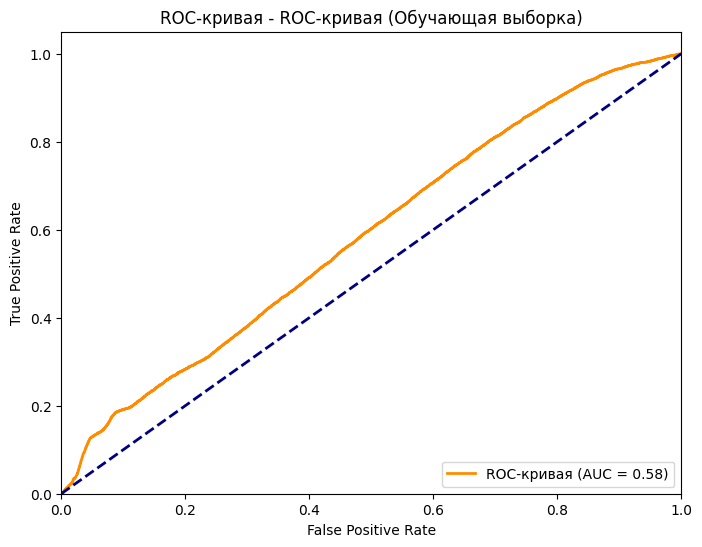

In [ ]:
# ELLIPTIC ENVELOPE
print(f"\n{'='*50}")
print("Метод: Elliptic Envelope - ОБУЧЕНИЕ")
print(f"{'='*50}")

# Обучение
start_time = time.time()
ee = EllipticEnvelope(contamination=0.1, random_state=42)
ee.fit(X_train_scaled)
train_time_ee = time.time() - start_time

# Предсказание на обучающей выборке
start_time = time.time()
y_pred_train_ee = (ee.predict(X_train_scaled) == -1).astype(int)
train_pred_time_ee = time.time() - start_time
y_score_train_ee = -ee.decision_function(X_train_scaled)

# Метрики на обучающей выборке
train_acc_ee = accuracy_score(y_train, y_pred_train_ee)
train_prec_ee = precision_score(y_train, y_pred_train_ee)
train_rec_ee = recall_score(y_train, y_pred_train_ee)
train_f1_ee = f1_score(y_train, y_pred_train_ee)
train_roc_ee = roc_auc_score(y_train, y_score_train_ee)

# Вывод метрик обучающей выборки
print("\nМетрики на обучающей выборке:")
print(f"Accuracy: {train_acc_ee:.4f}")
print(f"Precision: {train_prec_ee:.4f}")
print(f"Recall: {train_rec_ee:.4f}")
print(f"F1-score: {train_f1_ee:.4f}")
print(f"ROC AUC: {train_roc_ee:.4f}")
print(f"Время обучения: {train_time_ee:.4f} сек.")
print(f"Время предсказания: {train_pred_time_ee:.4f} сек.")

# Матрица ошибок для обучающей выборки
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_train, y_pred_train_ee, title='Матрица ошибок (Обучающая выборка)')
plt.show()

# ROC-кривая для обучающей выборки
plt.figure(figsize=(8, 6))
plot_roc_curve(y_train, y_score_train_ee, title='ROC-кривая (Обучающая выборка)')
plt.show()


Метод: Elliptic Envelope - ТЕСТИРОВАНИЕ

Метрики на тестовой выборке:
Accuracy: 0.8932
Precision: 0.0204
Recall: 0.1850
F1-score: 0.0368
ROC AUC: 0.5809
Время предсказания: 0.2121 сек.


<Figure size 800x600 with 0 Axes>

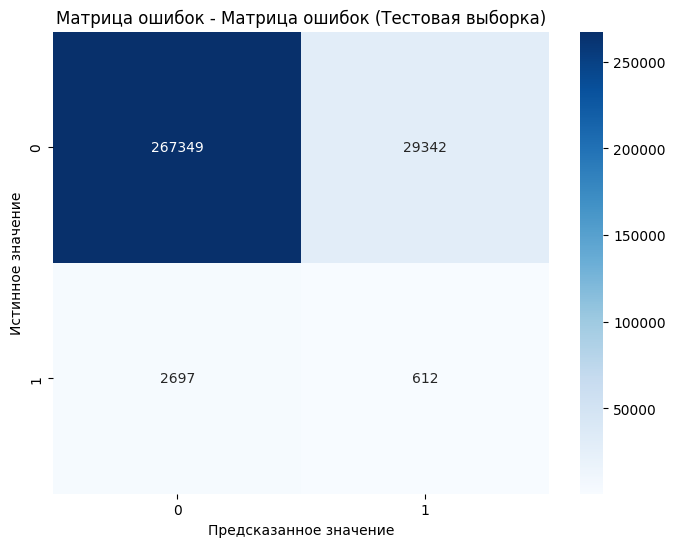

<Figure size 800x600 with 0 Axes>

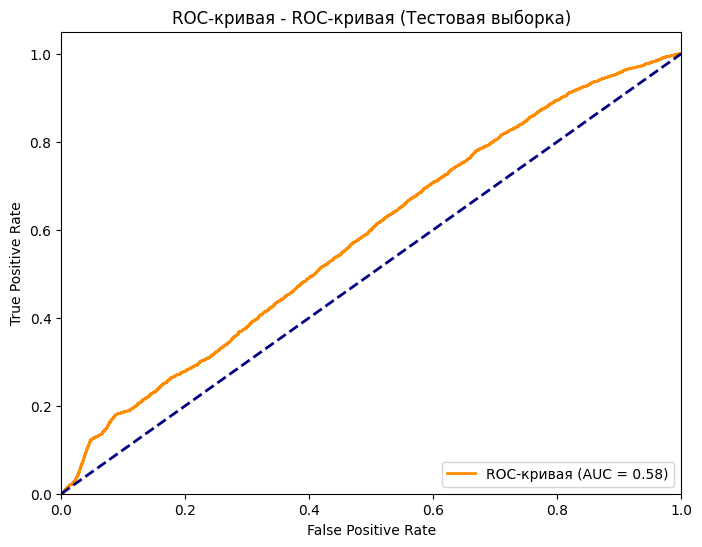

In [ ]:
print(f"\n{'='*50}")
print("Метод: Elliptic Envelope - ТЕСТИРОВАНИЕ")
print(f"{'='*50}")

# Предсказание на тестовой выборке
start_time = time.time()
y_pred_test_ee = (ee.predict(X_test_scaled) == -1).astype(int)
test_pred_time_ee = time.time() - start_time
y_score_test_ee = -ee.decision_function(X_test_scaled)

# Метрики на тестовой выборке
test_acc_ee = accuracy_score(y_test, y_pred_test_ee)
test_prec_ee = precision_score(y_test, y_pred_test_ee)
test_rec_ee = recall_score(y_test, y_pred_test_ee)
test_f1_ee = f1_score(y_test, y_pred_test_ee)
test_roc_ee = roc_auc_score(y_test, y_score_test_ee)

# Вывод метрик тестовой выборки
print("\nМетрики на тестовой выборке:")
print(f"Accuracy: {test_acc_ee:.4f}")
print(f"Precision: {test_prec_ee:.4f}")
print(f"Recall: {test_rec_ee:.4f}")
print(f"F1-score: {test_f1_ee:.4f}")
print(f"ROC AUC: {test_roc_ee:.4f}")
print(f"Время предсказания: {test_pred_time_ee:.4f} сек.")

# Матрица ошибок для тестовой выборки
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_test, y_pred_test_ee, title='Матрица ошибок (Тестовая выборка)')
plt.show()

# ROC-кривая для тестовой выборки
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_score_test_ee, title='ROC-кривая (Тестовая выборка)')
plt.show()


In [ ]:
# Сохранение результатов Elliptic Envelope
results_ee = {
    'train_accuracy_ee': train_acc_ee,
    'train_precision_ee': train_prec_ee,
    'train_recall_ee': train_rec_ee,
    'train_f1_ee': train_f1_ee,
    'train_roc_auc_ee': train_roc_ee,
    'train_time_ee': train_time_ee,
    'train_pred_time_ee': train_pred_time_ee,
    'test_accuracy_ee': test_acc_ee,
    'test_precision_ee': test_prec_ee,
    'test_recall_ee': test_rec_ee,
    'test_f1_ee': test_f1_ee,
    'test_roc_auc_ee': test_roc_ee,
    'test_pred_time_ee': test_pred_time_ee
}

## **Z-Score:**



Метод: Z-Score Detector

Метрики на обучающей выборке:
Accuracy: 0.7516
Precision: 0.0183
Recall: 0.4092
F1: 0.0351
Roc_auc: 0.6352
Время обучения: 0.1362 сек.
Время предсказания: 0.2748 сек.


<Figure size 800x600 with 0 Axes>

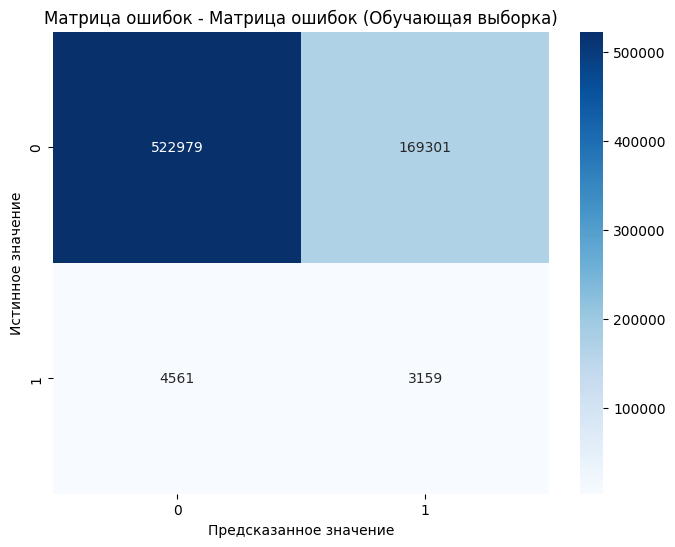

<Figure size 800x600 with 0 Axes>

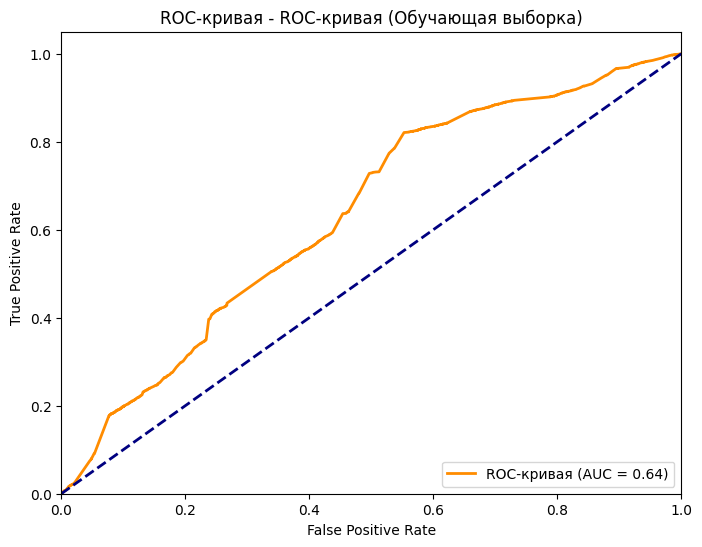

In [ ]:
import numpy as np
import time
from sklearn.base import BaseEstimator, OutlierMixin

class ZScoreDetector(BaseEstimator, OutlierMixin):
    def __init__(self, threshold=3.0):
        self.threshold = threshold
        self.mean_ = None
        self.std_ = None

    def fit(self, X, y=None):
        # Вычисляем среднее и стандартное отклонение
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0, ddof=1)  # ddof=1 для несмещенной оценки

        # Защита от деления на ноль
        self.std_[self.std_ == 0] = 1e-10

        return self

    def predict(self, X):
        # Проверяем, что модель обучена
        if self.mean_ is None or self.std_ is None:
            raise ValueError("Модель должна быть обучена перед использованием predict")

        # Вычисляем Z-scores для всех признаков
        z_scores = np.abs((X - self.mean_) / self.std_)

        # Определяем аномалии (1 - аномалия, 0 - норма)
        # Наблюдение считается аномальным, если хотя бы один признак
        # имеет z-score выше порогового значения
        is_outlier = (np.max(z_scores, axis=1) > self.threshold).astype(int)

        return is_outlier

    def decision_function(self, X):
        if self.mean_ is None or self.std_ is None:
            raise ValueError("Модель должна быть обучена перед использованием decision_function")

        # Вычисляем Z-scores
        z_scores = np.abs((X - self.mean_) / self.std_)

        # Возвращаем максимальный Z-score для каждого наблюдения
        return np.max(z_scores, axis=1)

# Пример использования:
# Создание и обучение модели
print(f"\n{'='*50}")
print("Метод: Z-Score Detector")
print(f"{'='*50}")

# Обучение
start_time = time.time()
zscore_detector = ZScoreDetector(threshold=3.0)
zscore_detector.fit(X_train_scaled)
train_time_zscore = time.time() - start_time

# Предсказание на обучающей выборке
start_time = time.time()
y_pred_train_zscore = zscore_detector.predict(X_train_scaled)
train_pred_time_zscore = time.time() - start_time
y_score_train_zscore = zscore_detector.decision_function(X_train_scaled)

train_acc_zscore = accuracy_score(y_train, y_pred_train_zscore)
train_prec_zscore = precision_score(y_train, y_pred_train_zscore)
train_rec_zscore = recall_score(y_train, y_pred_train_zscore)
train_f1_zscore = f1_score(y_train, y_pred_train_zscore)
train_roc_zscore = roc_auc_score(y_train, y_score_train_zscore)

# Метрики на обучающей выборке
train_metrics_zscore = {
    'accuracy': accuracy_score(y_train, y_pred_train_zscore),
    'precision': precision_score(y_train, y_pred_train_zscore),
    'recall': recall_score(y_train, y_pred_train_zscore),
    'f1': f1_score(y_train, y_pred_train_zscore),
    'roc_auc': roc_auc_score(y_train, y_score_train_zscore)
}

# Вывод метрик обучающей выборки
print("\nМетрики на обучающей выборке:")
for metric, value in train_metrics_zscore.items():
    print(f"{metric.capitalize()}: {value:.4f}")
print(f"Время обучения: {train_time_zscore:.4f} сек.")
print(f"Время предсказания: {train_pred_time_zscore:.4f} сек.")

# Визуализация результатов
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_train, y_pred_train_zscore,
                     title='Матрица ошибок (Обучающая выборка)')
plt.show()

plt.figure(figsize=(8, 6))
plot_roc_curve(y_train, y_score_train_zscore,
               title='ROC-кривая (Обучающая выборка)')
plt.show()


Метод: Z-Score - ТЕСТИРОВАНИЕ

Метрики на тестовой выборке:
Accuracy: 0.7505
Precision: 0.0184
Recall: 0.4137
F1-score: 0.0353
ROC AUC: 0.6362
Время предсказания: 0.1885 сек.


<Figure size 800x600 with 0 Axes>

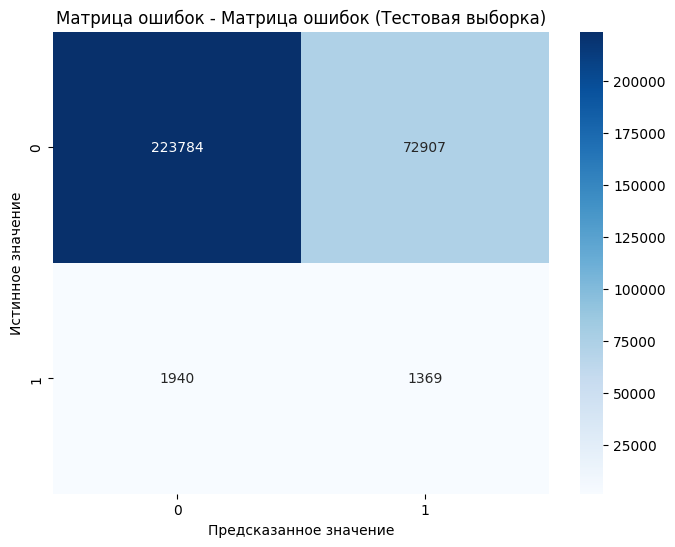

<Figure size 800x600 with 0 Axes>

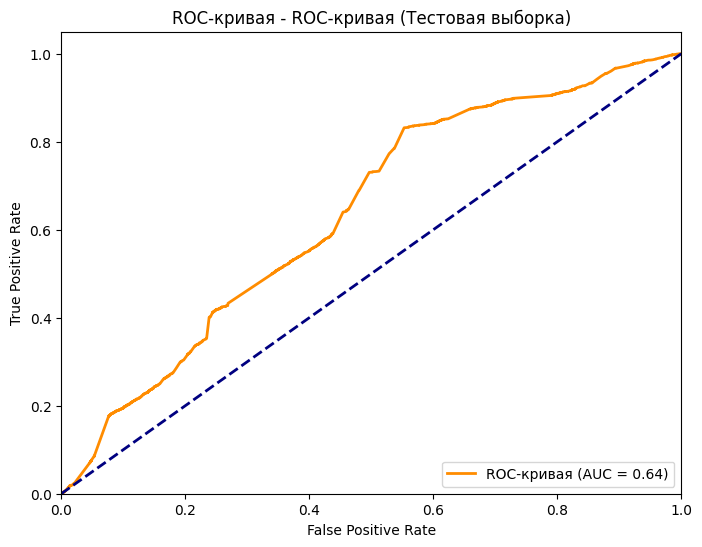

In [ ]:
print(f"\n{'='*50}")
print("Метод: Z-Score - ТЕСТИРОВАНИЕ")
print(f"{'='*50}")

# Предсказание на тестовой выборке
start_time = time.time()
y_pred_test_zscore = zscore_detector.predict(X_test_scaled)
test_pred_time_zscore = time.time() - start_time
y_score_test_zscore = zscore_detector.decision_function(X_test_scaled)

# Метрики на тестовой выборке
test_acc_zscore = accuracy_score(y_test, y_pred_test_zscore)
test_prec_zscore = precision_score(y_test, y_pred_test_zscore)
test_rec_zscore = recall_score(y_test, y_pred_test_zscore)
test_f1_zscore = f1_score(y_test, y_pred_test_zscore)
test_roc_zscore = roc_auc_score(y_test, y_score_test_zscore)

# Вывод метрик тестовой выборки
print("\nМетрики на тестовой выборке:")
print(f"Accuracy: {test_acc_zscore:.4f}")
print(f"Precision: {test_prec_zscore:.4f}")
print(f"Recall: {test_rec_zscore:.4f}")
print(f"F1-score: {test_f1_zscore:.4f}")
print(f"ROC AUC: {test_roc_zscore:.4f}")
print(f"Время предсказания: {test_pred_time_zscore:.4f} сек.")

# Матрица ошибок для тестовой выборки
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_test, y_pred_test_zscore, title='Матрица ошибок (Тестовая выборка)')
plt.show()

# ROC-кривая для тестовой выборки
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_score_test_zscore, title='ROC-кривая (Тестовая выборка)')
plt.show()


In [ ]:
# Сохранение результатов Z-Score
results_zscore = {
    'train_accuracy_zscore': train_acc_zscore,
    'train_precision_zscore': train_prec_zscore,
    'train_recall_zscore': train_rec_zscore,
    'train_f1_zscore': train_f1_zscore,
    'train_roc_auc_zscore': train_roc_zscore,
    'train_time_zscore': train_time_zscore,
    'train_pred_time_zscore': train_pred_time_zscore,
    'test_accuracy_zscore': test_acc_zscore,
    'test_precision_zscore': test_prec_zscore,
    'test_recall_zscore': test_rec_zscore,
    'test_f1_zscore': test_f1_zscore,
    'test_roc_auc_zscore': test_roc_zscore,
    'test_pred_time_zscore': test_pred_time_zscore
}

## **IQR:**

In [ ]:
import numpy as np
import time
from sklearn.base import BaseEstimator, OutlierMixin

class IQRDetector(BaseEstimator, OutlierMixin):
    def __init__(self, threshold=1.5):
        self.threshold = threshold
        self.q1_ = None
        self.q3_ = None
        self.iqr_ = None

    def fit(self, X, y=None):
        # Вычисляем квартили и IQR для каждого признака
        self.q1_ = np.percentile(X, 25, axis=0)
        self.q3_ = np.percentile(X, 75, axis=0)
        self.iqr_ = self.q3_ - self.q1_

        return self

    def predict(self, X):
        # Проверяем, что модель обучена
        if self.q1_ is None or self.q3_ is None or self.iqr_ is None:
            raise ValueError("Модель должна быть обучена перед использованием predict")

        # Вычисляем нижнюю и верхнюю границы
        lower_bound = self.q1_ - self.threshold * self.iqr_
        upper_bound = self.q3_ + self.threshold * self.iqr_

        # Определяем аномалии (1 - аномалия, 0 - норма)
        is_outlier = np.zeros(len(X))
        for i in range(len(X)):
            # Наблюдение - аномалия, если хотя бы один признак вне границ
            if np.any((X[i] < lower_bound) | (X[i] > upper_bound)):
                is_outlier[i] = 1

        return is_outlier

    def decision_function(self, X):
        if self.q1_ is None or self.q3_ is None or self.iqr_ is None:
            raise ValueError("Модель должна быть обучена перед использованием decision_function")

        # Вычисляем границы
        lower_bound = self.q1_ - self.threshold * self.iqr_
        upper_bound = self.q3_ + self.threshold * self.iqr_

        # Вычисляем отклонение от границ для каждого признака
        lower_deviation = np.maximum(0, lower_bound - X)
        upper_deviation = np.maximum(0, X - upper_bound)

        # Общее отклонение как максимум по всем признакам
        max_deviation = np.maximum(lower_deviation, upper_deviation)
        scores = np.max(max_deviation, axis=1)

        return scores


Метод: IQR - ОБУЧЕНИЕ

Метрики на обучающей выборке:
Accuracy: 0.1078
Precision: 0.0114
Recall: 0.9315
F1-score: 0.0225
ROC AUC: 0.5428
Время обучения: 2.0279 сек.
Время предсказания: 4.8526 сек.


<Figure size 800x600 with 0 Axes>

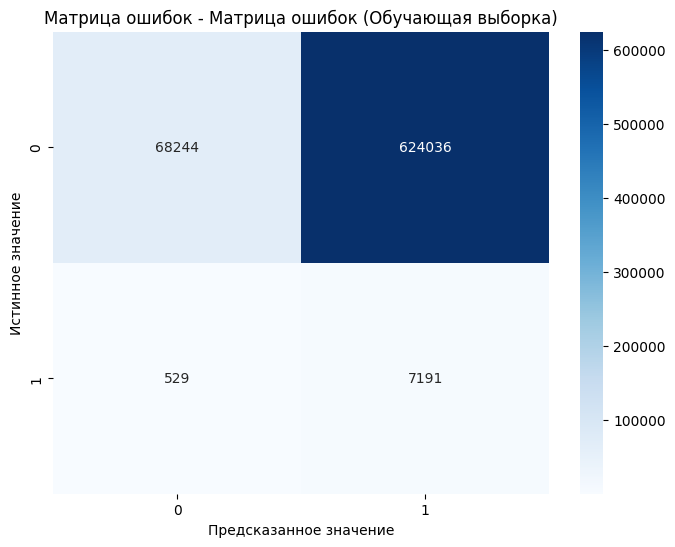

<Figure size 800x600 with 0 Axes>

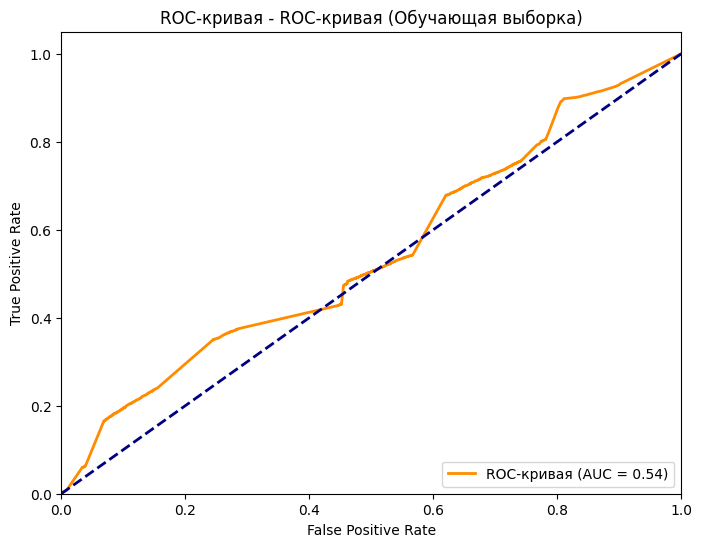

In [ ]:
# IQR
print(f"\n{'='*50}")
print("Метод: IQR - ОБУЧЕНИЕ")
print(f"{'='*50}")

X_train_normal_array = X_train_normal.to_numpy() if hasattr(X_train_normal, 'to_numpy') else X_train_normal
X_train_scaled_array = X_train_scaled.to_numpy() if hasattr(X_train_scaled, 'to_numpy') else X_train_scaled

# Обучение
start_time = time.time()
iqr = IQRDetector(threshold=1.5)
iqr.fit(X_train_scaled_array)
train_time_iqr = time.time() - start_time

# Предсказание на обучающей выборке
start_time = time.time()
y_pred_train_iqr = iqr.predict(X_train_scaled_array)
train_pred_time_iqr = time.time() - start_time
y_score_train_iqr = iqr.decision_function(X_train_scaled_array)

# Метрики на обучающей выборке
train_acc_iqr = accuracy_score(y_train, y_pred_train_iqr)
train_prec_iqr = precision_score(y_train, y_pred_train_iqr)
train_rec_iqr = recall_score(y_train, y_pred_train_iqr)
train_f1_iqr = f1_score(y_train, y_pred_train_iqr)
train_roc_iqr = roc_auc_score(y_train, y_score_train_iqr)

# Вывод метрик обучающей выборки
print("\nМетрики на обучающей выборке:")
print(f"Accuracy: {train_acc_iqr:.4f}")
print(f"Precision: {train_prec_iqr:.4f}")
print(f"Recall: {train_rec_iqr:.4f}")
print(f"F1-score: {train_f1_iqr:.4f}")
print(f"ROC AUC: {train_roc_iqr:.4f}")
print(f"Время обучения: {train_time_iqr:.4f} сек.")
print(f"Время предсказания: {train_pred_time_iqr:.4f} сек.")

# Матрица ошибок для обучающей выборки
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_train, y_pred_train_iqr, title='Матрица ошибок (Обучающая выборка)')
plt.show()

# ROC-кривая для обучающей выборки
plt.figure(figsize=(8, 6))
plot_roc_curve(y_train, y_score_train_iqr, title='ROC-кривая (Обучающая выборка)')
plt.show()



Метод: IQR - ТЕСТИРОВАНИЕ

Метрики на тестовой выборке:
Accuracy: 0.1080
Precision: 0.0114
Recall: 0.9353
F1-score: 0.0226
ROC AUC: 0.5406
Время предсказания: 2.0805 сек.


<Figure size 800x600 with 0 Axes>

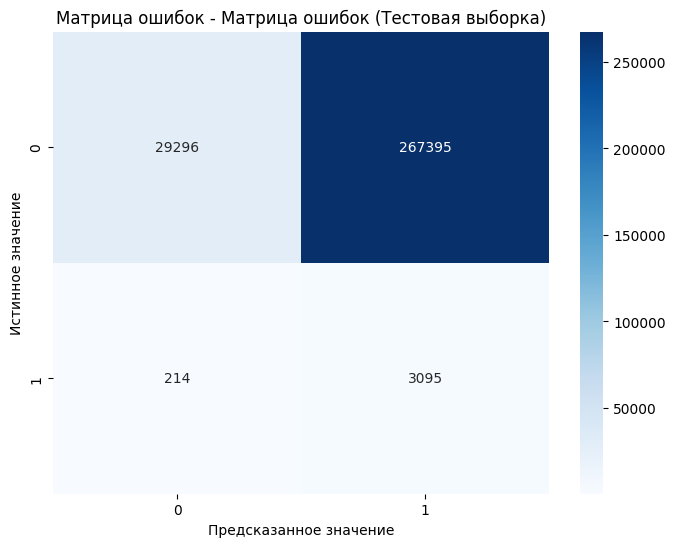

<Figure size 800x600 with 0 Axes>

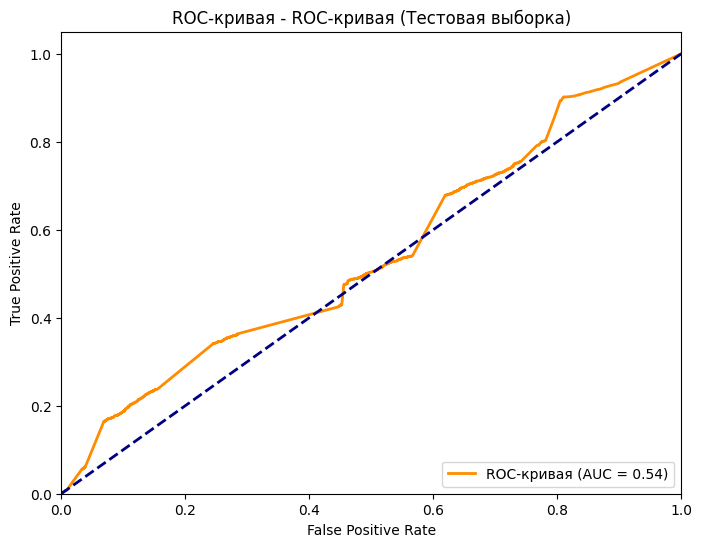

In [ ]:
print(f"\n{'='*50}")
print("Метод: IQR - ТЕСТИРОВАНИЕ")
print(f"{'='*50}")

X_test_scaled_array = X_test_scaled.to_numpy() if hasattr(X_test_scaled, 'to_numpy') else X_train_scaled

# Предсказание на тестовой выборке
start_time = time.time()
y_pred_test_iqr = iqr.predict(X_test_scaled_array)
test_pred_time_iqr = time.time() - start_time
y_score_test_iqr = iqr.decision_function(X_test_scaled_array)

# Метрики на тестовой выборке
test_acc_iqr = accuracy_score(y_test, y_pred_test_iqr)
test_prec_iqr = precision_score(y_test, y_pred_test_iqr)
test_rec_iqr = recall_score(y_test, y_pred_test_iqr)
test_f1_iqr = f1_score(y_test, y_pred_test_iqr)
test_roc_iqr = roc_auc_score(y_test, y_score_test_iqr)

# Вывод метрик тестовой выборки
print("\nМетрики на тестовой выборке:")
print(f"Accuracy: {test_acc_iqr:.4f}")
print(f"Precision: {test_prec_iqr:.4f}")
print(f"Recall: {test_rec_iqr:.4f}")
print(f"F1-score: {test_f1_iqr:.4f}")
print(f"ROC AUC: {test_roc_iqr:.4f}")
print(f"Время предсказания: {test_pred_time_iqr:.4f} сек.")

# Матрица ошибок для тестовой выборки
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_test, y_pred_test_iqr, title='Матрица ошибок (Тестовая выборка)')
plt.show()

# ROC-кривая для тестовой выборки
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_score_test_iqr, title='ROC-кривая (Тестовая выборка)')
plt.show()


In [ ]:
# Сохранение результатов IQR
results_iqr = {
    'train_accuracy_iqr': train_acc_iqr,
    'train_precision_iqr': train_prec_iqr,
    'train_recall_iqr': train_rec_iqr,
    'train_f1_iqr': train_f1_iqr,
    'train_roc_auc_iqr': train_roc_iqr,
    'train_time_iqr': train_time_iqr,
    'train_pred_time_iqr': train_pred_time_iqr,
    'test_accuracy_iqr': test_acc_iqr,
    'test_precision_iqr': test_prec_iqr,
    'test_recall_iqr': test_rec_iqr,
    'test_f1_iqr': test_f1_iqr,
    'test_roc_auc_iqr': test_roc_iqr,
    'test_pred_time_iqr': test_pred_time_iqr
}

## **ИТОГ:**


In [ ]:
# Создание сводной таблицы результатов
results = {
    'iforest': results_iforest,
    'ocsvm': results_ocsvm,
    'lof': results_lof,
    'ee': results_ee,
    'zscore': results_zscore,
    'iqr': results_iqr
}


In [ ]:
results_iforest = {
    'train_accuracy_iforest': train_acc_iforest,
    'train_precision_iforest': train_prec_iforest,
    'train_recall_iforest': train_rec_iforest,
    'train_f1_iforest': train_f1_iforest,
    'train_roc_auc_iforest': train_roc_iforest,
    'train_time_iforest': train_time_iforest,
    'train_pred_time_iforest': train_pred_time_iforest,
    'test_accuracy_iforest': test_acc_iforest,
    'test_precision_iforest': test_prec_iforest,
    'test_recall_iforest': test_rec_iforest,
    'test_f1_iforest': test_f1_iforest,
    'test_roc_auc_iforest': test_roc_iforest,
    'test_pred_time_iforest': test_pred_time_iforest
}

In [ ]:
results_df_train = pd.DataFrame({
    name: {
        'Время обучения (сек)': metrics[f'train_time_{name.lower().replace(" ", "_")}'],
        'Время предсказания (обучение) (сек)': metrics[f'train_pred_time_{name.lower().replace(" ", "_")}'],
        'ROC AUC (обучение)': metrics[f'train_roc_auc_{name.lower().replace(" ", "_")}'],
        'Precision (обучение)': metrics[f'train_precision_{name}'],
        'Recall (обучение)': metrics[f'train_recall_{name}'],
        'F1 (обучение)': metrics[f'train_f1_{name}'],
    }
    for name, metrics in results.items()
}).T

# Преобразование numpy.float64 в обычный float
results_df_train = results_df_train.applymap(lambda x: float(x) if isinstance(x, np.float64) else x)

# Сортировка столбцов (опционально)
results_df_train = results_df_train[[
    'Время обучения (сек)',
    'ROC AUC (обучение)',
    'Precision (обучение)',
    'Recall (обучение)',
    'F1 (обучение)'
]]
results_df_train.index = ['Isolation Forest', 'One Class SVM', 'Local Outlier Factor',
                          'Elliptic Envelope', 'Z-Score', 'IQR']

# Округление чисел (опционально)
results_df_train = results_df_train.round(4)

results_df_train

<ipython-input-33-74c6bdc1cb86>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_df_train = results_df_train.applymap(lambda x: float(x) if isinstance(x, np.float64) else x)


,Время обучения (сек),ROC AUC (обучение),Precision (обучение),Recall (обучение),F1 (обучение)
Isolation Forest,27.3183,0.6636,0.0257,0.2330,0.0463
One Class SVM,14009.4275,0.6251,0.0236,0.2144,0.0426
Local Outlier Factor,3190.6438,0.5301,0.0135,0.1148,0.0241
Elliptic Envelope,98.3941,0.5847,0.0211,0.1909,0.0379
Z-Score,0.1362,0.6352,0.0183,0.4092,0.0351
IQR,2.0279,0.5428,0.0114,0.9315,0.0225


In [ ]:
# Сортировка по ROC AUC (обучение)
results_df1 = results_df_train.sort_values('ROC AUC (обучение)', ascending=False)

print("\n=== Итоговое сравнение всех методов ===")
print("\nСводная таблица результатов:")
results_df1


=== Итоговое сравнение всех методов ===

Сводная таблица результатов:


,Время обучения (сек),ROC AUC (обучение),Precision (обучение),Recall (обучение),F1 (обучение)
Isolation Forest,27.3183,0.6636,0.0257,0.2330,0.0463
Z-Score,0.1362,0.6352,0.0183,0.4092,0.0351
One Class SVM,14009.4275,0.6251,0.0236,0.2144,0.0426
Elliptic Envelope,98.3941,0.5847,0.0211,0.1909,0.0379
IQR,2.0279,0.5428,0.0114,0.9315,0.0225
Local Outlier Factor,3190.6438,0.5301,0.0135,0.1148,0.0241


In [ ]:
results_df_test = pd.DataFrame({
    name: {
        'Время обучения (сек)': metrics[f'train_time_{name.lower().replace(" ", "_")}'],
        'Время предсказания (тест) (сек)': metrics[f'test_pred_time_{name.lower().replace(" ", "_")}'],
        'ROC AUC (тест)': metrics[f'test_roc_auc_{name.lower().replace(" ", "_")}'],
        'Precision (тест)': metrics[f'test_precision_{name}'],
        'Recall (тест)': metrics[f'test_recall_{name}'],
        'F1 (тест)': metrics[f'test_f1_{name}'],
    }
    for name, metrics in results.items()
}).T

# Преобразование numpy.float64 в обычный float
results_df_test = results_df_test.applymap(lambda x: float(x) if isinstance(x, np.float64) else x)

# Сортировка столбцов (опционально)
results_df_test = results_df_test[[
    'Время предсказания (тест) (сек)',
    'ROC AUC (тест)',
    'Precision (тест)',
    'Recall (тест)',
    'F1 (тест)'
]]

results_df_test.index = ['Isolation Forest', 'One Class SVM', 'Local Outlier Factor',
                          'Elliptic Envelope', 'Z-Score', 'IQR']

# Округление чисел (опционально)
results_df_test = results_df_test.round(4)

results_df_test

<ipython-input-34-7b9fcf12967e>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_df_test = results_df_test.applymap(lambda x: float(x) if isinstance(x, np.float64) else x)


,Время предсказания (тест) (сек),ROC AUC (тест),Precision (тест),Recall (тест),F1 (тест)
Isolation Forest,13.1366,0.6632,0.0250,0.2279,0.0451
One Class SVM,1827.3822,0.6178,0.0228,0.2076,0.0410
Local Outlier Factor,1364.1784,0.5265,0.0134,0.1224,0.0241
Elliptic Envelope,0.2121,0.5809,0.0204,0.1850,0.0368
Z-Score,0.1885,0.6362,0.0184,0.4137,0.0353
IQR,2.0805,0.5406,0.0114,0.9353,0.0226


## **Построение графиков для сравнения**


In [ ]:
# Сортировка по ROC AUC (тест)
results_df = results_df_test.sort_values('ROC AUC (тест)', ascending=False)

print("\n=== Итоговое сравнение всех методов ===")
print("\nСводная таблица результатов:")
results_df


=== Итоговое сравнение всех методов ===

Сводная таблица результатов:


,Время предсказания (тест) (сек),ROC AUC (тест),Precision (тест),Recall (тест),F1 (тест)
Isolation Forest,13.1366,0.6632,0.0250,0.2279,0.0451
Z-Score,0.1885,0.6362,0.0184,0.4137,0.0353
One Class SVM,1827.3822,0.6178,0.0228,0.2076,0.0410
Elliptic Envelope,0.2121,0.5809,0.0204,0.1850,0.0368
IQR,2.0805,0.5406,0.0114,0.9353,0.0226
Local Outlier Factor,1364.1784,0.5265,0.0134,0.1224,0.0241


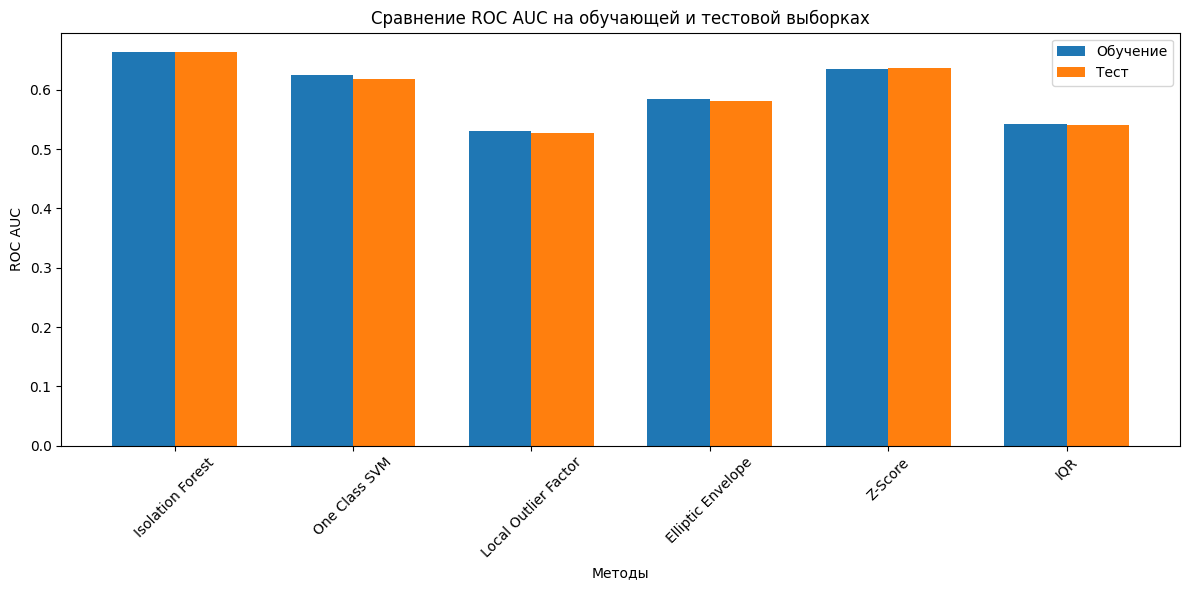

In [ ]:
# 1. График ROC AUC (обучение и тест)
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df_train.index))
width = 0.35

plt.bar(x - width/2, results_df_train['ROC AUC (обучение)'], width, label='Обучение')
plt.bar(x + width/2, results_df_test['ROC AUC (тест)'], width, label='Тест')

plt.xlabel('Методы')
plt.ylabel('ROC AUC')
plt.title('Сравнение ROC AUC на обучающей и тестовой выборках')
plt.xticks(x, results_df_train.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

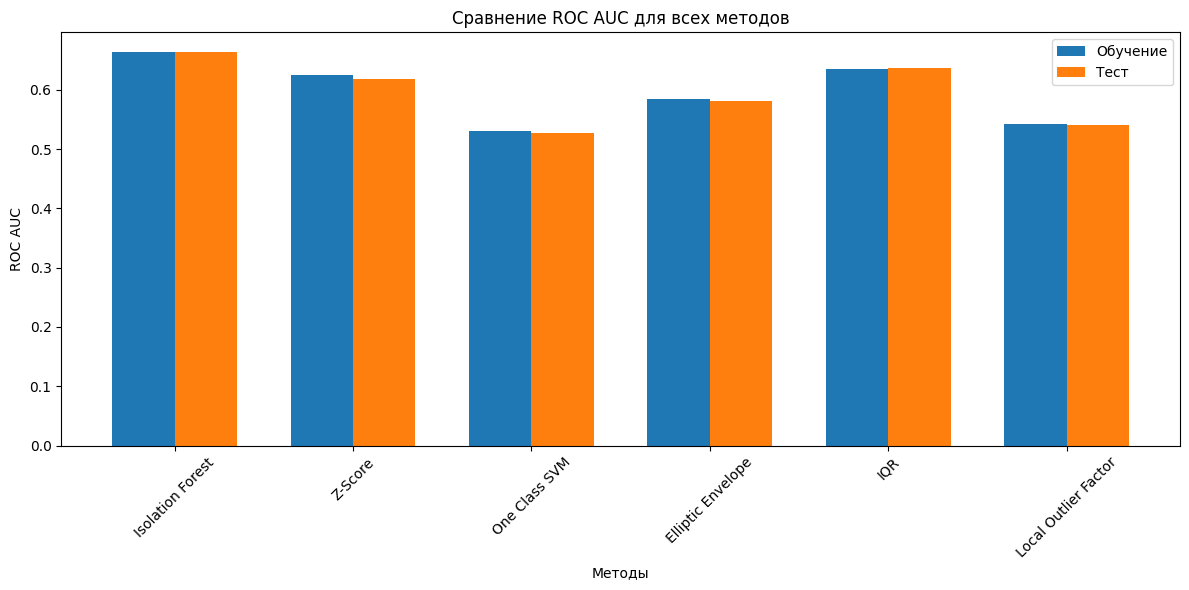

In [ ]:
# Построение сравнительного графика ROC AUC
plt.figure(figsize=(12, 6))
width = 0.35
x = np.arange(len(results))
plt.bar(x - width/2, results_df_train['ROC AUC (обучение)'], width, label='Обучение')
plt.bar(x + width/2, results_df_test['ROC AUC (тест)'], width, label='Тест')
plt.xlabel('Методы')
plt.ylabel('ROC AUC')
plt.title('Сравнение ROC AUC для всех методов')
plt.xticks(x, results_df.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

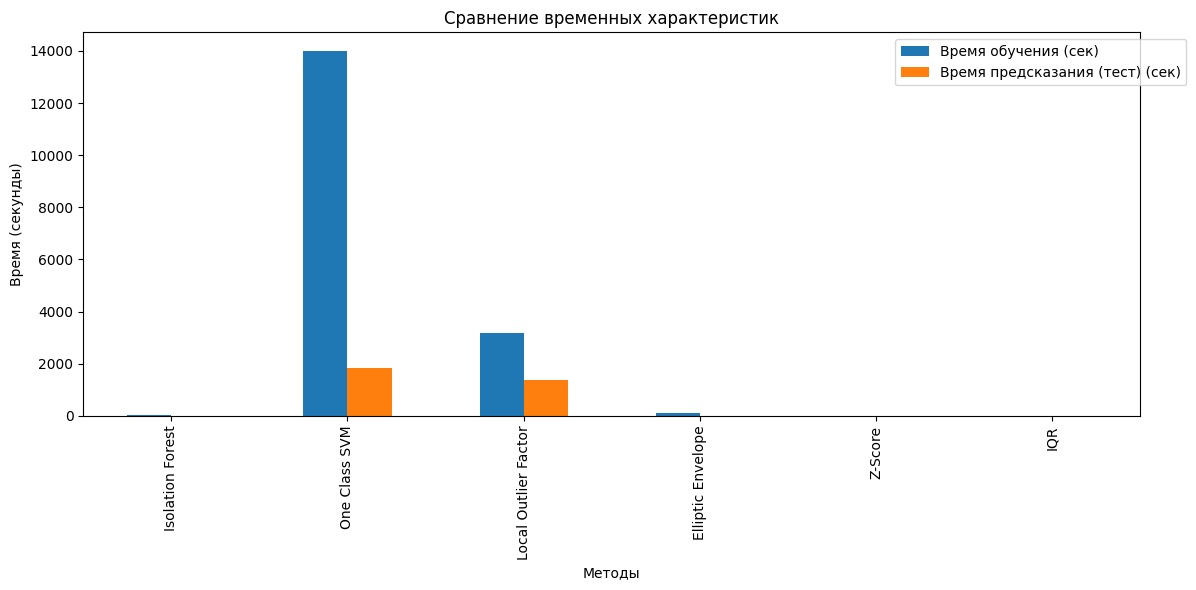

In [ ]:
# 2. График времени выполнения
plt.figure(figsize=(12, 6))
time_data = pd.concat([results_df_train[['Время обучения (сек)']],
                      results_df_test[['Время предсказания (тест) (сек)']]], axis=1)
time_data.plot(kind='bar', figsize=(12, 6))
plt.title('Сравнение временных характеристик')
plt.xlabel('Методы')
plt.ylabel('Время (секунды)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [ ]:
# Вывод лучшего метода
best_method = results_df_test.index[0]
best_roc_auc = results_df_test.loc[best_method, 'ROC AUC (тест)']
print(f"\nЛучший метод: {best_method}")
print(f"ROC AUC на тестовой выборке: {best_roc_auc:.4f}")


Лучший метод: Isolation Forest
ROC AUC на тестовой выборке: 0.6632
